In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import classification_report
import numpy as np


# Adjust the path to wherever you uploaded/archive.csv in Drive or Colab
df = pd.read_csv('/content/drive/MyDrive/content/drive/AI_Human.csv')
print(df.shape)
print(df.head())

n = 10_000

# 1) Muestrea 10 000 textos generados por IA
ones  = df[df['generated'] == 1.0].sample(n=n, random_state=42)

# 2) Muestrea 10 000 textos humanos
zeros = df[df['generated'] == 0.0].sample(n=n, random_state=42)

# 3. concatenar y mezclar
balanced = pd.concat([ones, zeros]) \
               .sample(frac=1, random_state=16) \
               .reset_index(drop=True)

print(f"Balanced dataset shape: {balanced.shape}")

# (Optional) Basic cleaning
balanced['text'] = balanced['text'].str.replace(r'\s+', ' ', regex=True).str.strip()

# Train/test split (80/10/10)
train_df, temp_df = train_test_split(balanced, test_size=0.2, random_state=16, stratify=balanced['generated'])
val_df, test_df  = train_test_split(temp_df, test_size=0.5, random_state=16, stratify=temp_df['generated'])

print(f"Test set shape: {test_df.shape}")

# 1. Vectorize
vectorizer = TfidfVectorizer(max_features=50_000, ngram_range=(1,2))
X_train = vectorizer.fit_transform(train_df['text'])
X_val   = vectorizer.transform(val_df['text'])
X_test  = vectorizer.transform(test_df['text'])

# 2. Define the Random Forest and the search space
rf = RandomForestClassifier(random_state=42, n_jobs=-1)

param_dist = {
    'n_estimators':      [100, 300, 500],
    'max_depth':         [None, 10, 20, 30],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf':  [1, 2, 4],
    'bootstrap':         [True, False]
}

# 3. Run a randomized search
search = RandomizedSearchCV(
    rf,
    param_distributions=param_dist,
    n_iter=50,              # how many random combinations to try
    scoring='f1',           # pick the metric you care about
    cv=3,                   # 3-fold cross‐validation
    verbose=2,
    random_state=42,
    n_jobs=-1
)

search.fit(X_train, train_df['generated'])

print("Best params:", search.best_params_)
print("Best CV score:", search.best_score_)

# 4. Evaluate on validation set
best_rf = search.best_estimator_
preds = best_rf.predict(X_val)
print(classification_report(val_df['generated'], preds))

(487235, 2)
                                                text  generated
0  Cars. Cars have been around since they became ...        0.0
1  Transportation is a large necessity in most co...        0.0
2  "America's love affair with it's vehicles seem...        0.0
3  How often do you ride in a car? Do you drive a...        0.0
4  Cars are a wonderful thing. They are perhaps o...        0.0
Balanced dataset shape: (20000, 2)
Test set shape: (2000, 2)
Fitting 3 folds for each of 50 candidates, totalling 150 fits
Best params: {'n_estimators': 300, 'min_samples_split': 5, 'min_samples_leaf': 1, 'max_depth': None, 'bootstrap': False}
Best CV score: 0.9822165805046668
              precision    recall  f1-score   support

         0.0       0.98      0.99      0.99      1000
         1.0       0.99      0.98      0.99      1000

    accuracy                           0.99      2000
   macro avg       0.99      0.99      0.99      2000
weighted avg       0.99      0.99      0.99      2000


In [ ]:
import joblib

joblib.dump(best_rf,  'rf_best_model.joblib')
joblib.dump(vectorizer, 'tfidf_vectorizer.joblib')

print("Model and vectorizer saved to disk.")

Model and vectorizer saved to disk.


# Predicción del modelo sobre nuevos textos

In [ ]:
text1 = [
    """The use of this technology to great the emotional expressions of students in a classroom
    is valuable because it involves anything to communicate. The quote says, "The process begins
    when the computer constructs a 3D computer motel of the face."""
]

text1_vec = vectorizer.transform(text1)
preds = best_rf.predict(text1_vec)
print(f"Predicción: {preds[0]} (0 = humano, 1 = IA)")

Predicción: 0.0 (0 = humano, 1 = IA)


In [ ]:
text2 = pd.Series("In a sentence if we are going to use all 3 pronouns. Should it be or something else")
text2_vec = vectorizer.transform(text2)
preds = best_rf.predict(text2_vec)
print(f"Predicción: {preds[0]} (0 = humano, 1 = IA)")

Predicción: 1.0 (0 = humano, 1 = IA)


# Distribución de textos en el dataset original

In [ ]:
total = df.shape[0]
ai_count = df[df['generated'] == 1].shape[0]
human_count = df[df['generated'] == 0].shape[0]
porcentaje_ia = ai_count * 100 / total
print(f"Porcentaje de textos generados por IA: {porcentaje_ia:.2f}%")
porcentaje_human = human_count * 100 / total
print(f"Porcentaje de textos escritos por humanos: {porcentaje_human:.2f}%")

Porcentaje de textos generados por IA: 37.24%
Porcentaje de textos escritos por humanos: 62.76%


# Distribución de textos en el conjunto de entrenamiento (train_df)

In [ ]:
total = train_df.shape[0]
ai_count = train_df[train_df['generated'] == 1].shape[0]
human_count = train_df[train_df['generated'] == 0].shape[0]
porcentaje_ia = ai_count * 100 / total
print(f"Porcentaje de textos generados por IA: {porcentaje_ia:.2f}%")
porcentaje_human = human_count * 100 / total
print(f"Porcentaje de textos escritos por humanos: {porcentaje_human:.2f}%")

Porcentaje de textos generados por IA: 50.00%
Porcentaje de textos escritos por humanos: 50.00%


# Evaluación sobre el set de test

In [ ]:
test_preds = best_rf.predict(X_test)
# Calculate and display test set performance
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

print(f"Precisión: {accuracy_score(test_df['generated'], test_preds):.4f}")
print("Reporte de clasificación:")
print(classification_report(test_df['generated'], test_preds))

Precisión: 0.9870
Reporte de clasificación:
              precision    recall  f1-score   support

         0.0       0.98      0.99      0.99      1000
         1.0       0.99      0.98      0.99      1000

    accuracy                           0.99      2000
   macro avg       0.99      0.99      0.99      2000
weighted avg       0.99      0.99      0.99      2000



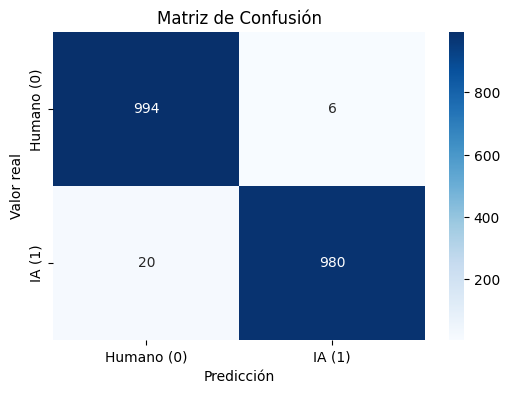

In [ ]:
# Generar la matriz
cm = confusion_matrix(test_df['generated'], test_preds)

# Dibujar el gráfico
plt.figure(figsize=(6, 4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Humano (0)', 'IA (1)'], yticklabels=['Humano (0)', 'IA (1)'])
plt.xlabel('Predicción')
plt.ylabel('Valor real')
plt.title('Matriz de Confusión')
plt.show()

# Predicciones de ejemplo sobre el set de test

In [ ]:
# Show first 50 examples
for i in range(min(50, len(test_df))):
    actual = test_df.iloc[i]['generated']
    predicted = test_preds[i]
    text_sample = test_df.iloc[i]['text'][:100] + "..." if len(test_df.iloc[i]['text']) > 100 else test_df.iloc[i]['text']

    status = "✓" if actual == predicted else "✗"
    print(f"{status} Actual: {actual} | Predicted: {predicted} | Text: {text_sample}")

✓ Actual: 0.0 | Predicted: 0.0 | Text: I think You should choose police one because the student aren't going to like it and cause problems ...
✓ Actual: 0.0 | Predicted: 0.0 | Text: Some advantages of limiting car usage is definitely that it would help not polite the air. With so m...
✓ Actual: 0.0 | Predicted: 0.0 | Text: If I were to choose between keeping the electoral college or abolishing it, I would chose for abolis...
✓ Actual: 1.0 | Predicted: 1.0 | Text: The increasing focus on reducing greenhouse gas emissions and the negative impact of car usage on th...
✓ Actual: 1.0 | Predicted: 1.0 | Text: Seeking multiple opinions is a crucial aspect of making informed decisions. It allows individuals to...
✓ Actual: 0.0 | Predicted: 0.0 | Text: Dear TEACHER_NAME , I think cell phones should be allowed at school and to used only during free per...
✓ Actual: 0.0 | Predicted: 0.0 | Text: I write this to the Senator of Florida. Every four year a president ix elected to become what ix the...

# Ejemplos

In [ ]:
import joblib

# Cargar el modelo entrenado
modelo = joblib.load('/content/drive/MyDrive/aprendizajeAutomatico/rf_best_model.joblib')

# Cargar el vectorizador TF-IDF
vectorizador = joblib.load('/content/drive/MyDrive/aprendizajeAutomatico/tfidf_vectorizer.joblib')


### Ejemplos hechos por humanos

In [ ]:
new_text = [
    "I read a post on Askreddit that inquired, “what are some completely legal things that make you a terrible human being.” Among the top comments were answers like, standing in the middle of an aisle, not flushing the toilet, or not putting things back where you found them in the grocery store. All these comments had 5 digit upvotes. Are these things somewhat inconsiderate and annoying? Yes. Do they make you a terrible person? No. I feel like these people who view these actions as “terrible” are just looking for any way to feel validated in their perceived moral superiority by barely doing anything at all. They think “I don’t stand in people’s way, I flush the toilet, I put grocery items back where I found them, I’m a good person and other people are bad”. It honestly feels somewhat masturbatory. I think you can do inconsiderate things and even have committed crimes and still be a good person, if you were perfect you wouldn’t be human. I can pick apart someone’s every action and try to place them neatly into the categories of “good” and “bad” but it probably wouldn’t make me any better as a person."
]
text1_vec = vectorizador.transform(new_text)
preds = modelo.predict(text1_vec)
print(f"Predicción: {preds[0]} (0 = humano, 1 = IA)")

Predicción: 0.0 (0 = humano, 1 = IA)


In [ ]:

new_text = [
    """The use of this technology to create the emotional expressions of students in a classroom
    is valuable because it enables communication. The quote says, "The process begins
    when the computer constructs a 3D computer model of the face."""
]

text1_vec = vectorizador.transform(new_text)
preds = modelo.predict(text1_vec)
print(f"Predicción: {preds[0]} (0 = humano, 1 = IA)")


Predicción: 0.0 (0 = humano, 1 = IA)


In [ ]:
new_text = [
    "I used to rent, so I always used a TV stand. No mess, no stress. But when I finally bought my own place, I figured it was time to do it right and wall-mount the TV. That lasted about two weeks. The height felt off, I couldnt adjust anything without unbolting the whole thing, and dont even get me started on the cable situation. It looked good for about five minutes, then just became a pain. Ended up going back and re-ordering the same fitueyes tv stand I had in my rental. I had left it behind for the next tenant because I thought Id moved on from that phase. Turns out I hadnt. Sometimes the simple option is just... better. Now Im sitting here wondering why wall mounting became the “default” when its such a pain to do right and almost impossible to undo. Feels like we all just accepted it because it looks nice on Instagram. (even though the tv stand can looks nice too?)"
]

text1_vec = vectorizador.transform(new_text)
preds = modelo.predict(text1_vec)
print(f"Predicción: {preds[0]} (0 = humano, 1 = IA)")


Predicción: 0.0 (0 = humano, 1 = IA)


In [ ]:
new_text = [
    "I dont know why everyone on Reddit whines and cries about carts not being returned at the supermarket. When I was 15 I had a supermarket job. When I was asked to do carts I was ecstatic, got to go outdoors, got to not deal with annoying customers while bagging. Got to chill with the weird 30 y/o produce guy who hung out under the awning smoking, Why would a kid nowadays want to stay indoors and bag or cashier and deal with annoying people? Just go outside and stretch your legs, maybe sneak over to the other stores in the plaza, whatever. Youre giving these kids something fun to do, whats wrong with that?"
]

text1_vec = vectorizador.transform(new_text)
preds = modelo.predict(text1_vec)
print(f"Predicción: {preds[0]} (0 = humano, 1 = IA)")

Predicción: 0.0 (0 = humano, 1 = IA)


### Ejemplos hechos por IA

In [ ]:

new_text = [
    "In today’s fast-paced and increasingly interconnected global society, the importance of leveraging technological advancements to optimize learning outcomes cannot be overstated. Artificial intelligence, in particular, provides a wide range of opportunities for enhancing educational efficiency, engagement, and accessibility across diverse populations. By integrating adaptive algorithms, data-driven insights, and scalable platforms, institutions can foster a more personalized and inclusive learning environment that aligns with 21st-century skills and evolving industry demands."
]

text1_vec = vectorizador.transform(new_text)
preds = modelo.predict(text1_vec)
print(f"Predicción: {preds[0]} (0 = humano, 1 = IA)")


Predicción: 1.0 (0 = humano, 1 = IA)


In [ ]:
new_text = [
    "Learning a new language can be both exciting and challenging. Many people find that consistent practice and exposure to real conversations help improve their skills more effectively than just studying grammar rules. Using apps, watching movies, and talking with native speakers are great ways to immerse yourself in the language. Remember, making mistakes is a natural part of the learning process, and patience is key to becoming fluent."
]
text1_vec = vectorizador.transform(new_text)
preds = modelo.predict(text1_vec)
print(f"Predicción: {preds[0]} (0 = humano, 1 = IA)")

Predicción: 1.0 (0 = humano, 1 = IA)


In [ ]:
new_text = [
    "Traveling to new places is an amazing way to broaden your horizons and learn about different cultures. It allows you to meet new people, try unique foods, and experience traditions that you might never encounter otherwise. Whether it's a weekend getaway or a longer trip abroad, every journey has the potential to teach you something valuable and create lasting memories"
]
text1_vec = vectorizador.transform(new_text)
preds = modelo.predict(text1_vec)
print(f"Predicción: {preds[0]} (0 = humano, 1 = IA)")

Predicción: 1.0 (0 = humano, 1 = IA)


In [ ]:
new_text = [
    "I didn’t expect to enjoy cooking as much as I do now. It started as something I had to do just to get by, but over time, trying out new recipes became something I genuinely look forward to. It’s relaxing, and there’s a small sense of pride when a dish turns out well—especially when someone else enjoys it too."
]
text1_vec = vectorizador.transform(new_text)
preds = modelo.predict(text1_vec)
print(f"Predicción: {preds[0]} (0 = humano, 1 = IA)")

Predicción: 1.0 (0 = humano, 1 = IA)
